# Analysis of BTSP-enabled local sensitive hashing performance 2

In [2]:
# import dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
import xgboost as xgb

## Load dataset and check data

In [3]:
# load results.csv
results = pd.read_csv('merged_results.csv')

# print dataset length
print(len(results))

# print schema
print(results.dtypes)

9800
Unnamed: 0                 int64
dataset_name              object
training_data_num          int64
hash_length                int64
space_ratio                int64
btsp_fq_constant_x         int64
binary_mode                 bool
btsp_sampling_ratio_x    float64
random_seed                int64
experiment_index           int64
input_dim                  int64
embedding_size             int64
btsp_fq_constant_y         int64
btsp_sampling_ratio_y    float64
btsp_fq                  float64
btsp_mAP                 float64
dtype: object


## Empirical dataset-specific parameter importance analysis of BTSP-LSH performance

In this part, we explore: what are the most important parameters that affect the performance of BTSP-LSH? We will use the dataset from the previous part and the same experimental setup.

Our candidate parameters includes: `hash_length`, `space_ratio`, `btsp_fq_constant`, `btsp_sampling_ratio`. Note that `binary_mode` is not included in this analysis because we have already shown that it is not important in previous experiments.

We will use a XGBoost model with simple logistic regression as the base learner to analyze the importance(F score) of these parameters. Because a simple logistic regression may not represent the real relationship between the parameters and the performance, we regard the importance as a empirical reference that require further numerical analysis.

In [1]:
# data cleaning
# keep the columns we need
# dataset_name, hash_length, space_ratio, binary_mode, sampling_ratio, and all mAP columns
meta_results = results.drop(
    columns=[
        "training_data_num",
        "random_seed",
        "experiment_index",
        "input_dim",
        "embedding_size",
        "btsp_fq",
        "btsp_fq_constant_y",
        "btsp_sampling_ratio_y",
        "binary_mode",
    ]
)
# remove index column
meta_results = meta_results.drop(columns=["Unnamed: 0"])

# separate data for each dataset
datasets = meta_results["dataset_name"].unique()
for dataset in datasets:
    # XGB analysis
    curr_dataset_data = meta_results[meta_results["dataset_name"] == dataset]
    # remove dataset_name column
    curr_dataset_data = curr_dataset_data.drop(columns=["dataset_name"])
    # separate parameters and mAP columns
    mAP_types = ["btsp_mAP"]
    curr_dataset_params = curr_dataset_data.drop(mAP_types, axis=1)
    # normalize the parameters
    curr_dataset_params = (
        curr_dataset_params - curr_dataset_params.mean()
    ) / curr_dataset_params.std()

    # prepare XGBoost data
    X = curr_dataset_params
    # for each mAP type, use XGBoost to find the importance of each parameter
    mAP_types_importance = []
    for mAP_type in mAP_types:
        y = curr_dataset_data[mAP_type]
        dtrain = xgb.DMatrix(X, label=y)

        # set parameters
        # choose a parameter suitable for non-linear regression
        params = {
            "objective": "reg:logistic",
            "booster": "gbtree",
            "eta": 0.05,
        }
        # train the model
        bst = xgb.train(params, dtrain)
        # print error
        print(bst.eval(dtrain))

        # get feature importance and convert to numpy array
        importance = bst.get_score(importance_type="weight")
        # check if each parameter is in the importance
        # if not, add it with 0 importance
        for param in curr_dataset_params.columns:
            if param not in importance:
                importance[param] = 0
        # for debugging
        # print(importance)
        # normalize the importance
        importance = np.array(list(importance.values()))
        importance = importance / importance.max()
        # print(importance)

        mAP_types_importance.append(importance)

    # plot importance heatmap
    norm = plt.Normalize(0, 1)
    fig, ax = plt.subplots()
    im = ax.imshow(mAP_types_importance, norm=norm, cmap="coolwarm")
    ax.set_xticks(np.arange(len(curr_dataset_params.columns)))
    ax.set_yticks(np.arange(len(mAP_types)))
    ax.set_xticklabels(curr_dataset_params.columns)
    ax.set_yticklabels(mAP_types)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fig.tight_layout()
    # add title
    plt.title("Relative Importance of Parameters for " + dataset)
    # add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    plt.show()
    # close the plot
    plt.close()

NameError: name 'results' is not defined

## Parameter-specific performance analysis of the BTSP-LSH algorithm

From empirical analysis, we find that `hash_length`, `space_ratio` and `sampling_ratio` all have considerable impact on the performance of the algorithms, while `btsp_fq_constant` has relative little impact. We will analyze the performance of the algorithm under different parameter settings.

To elaborate, for each parameter, we will separate data from each dataset into chunks where only the parameter of interest is changed, and calculate the coefficient of variation of the performance(mAP). Apply the same analysis to all chunks, we will get a distribution of the coefficient of variation of the performance under different parameter settings. This distribution reflects how much the parameter of interest affects the performance of the algorithm.

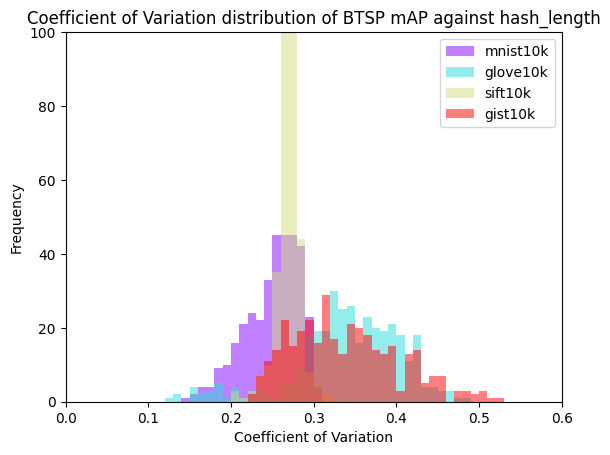

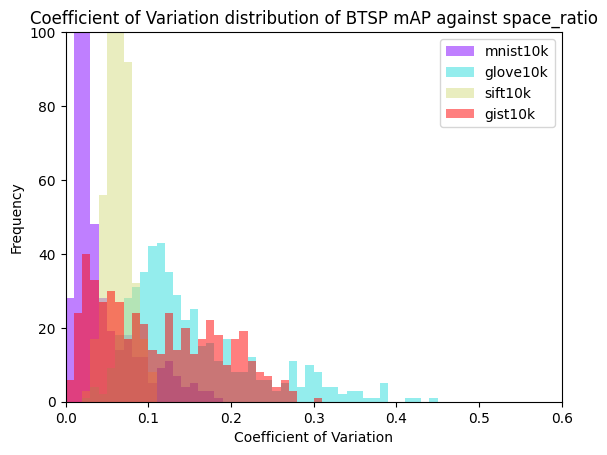

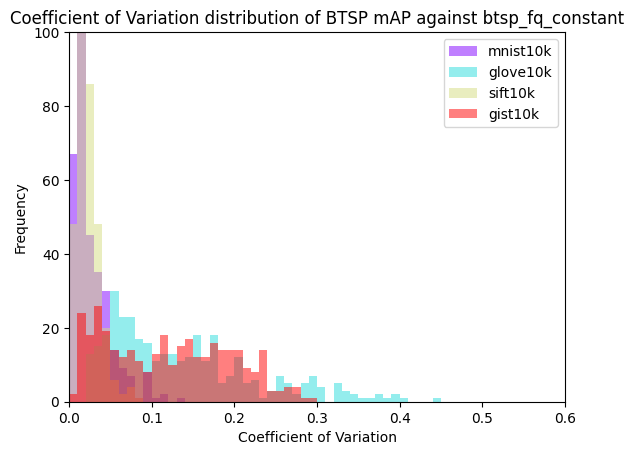

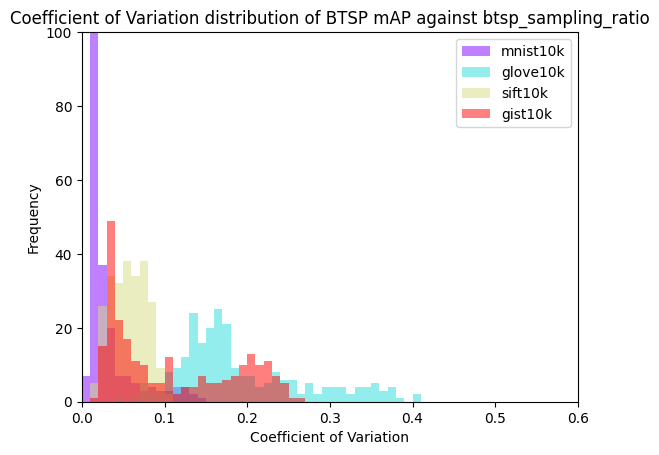

In [6]:
# load merged result
results = pd.read_csv('merged_results.csv')

# data cleaning
# select relevant columns
columns = ["dataset_name", "hash_length","space_ratio","btsp_fq_constant_x","btsp_sampling_ratio_x","btsp_mAP"]

# discard other columns
data = results[columns]

# rename columns
data = data.rename(columns={"btsp_fq_constant_x":"btsp_fq_constant","btsp_sampling_ratio_x":"btsp_sampling_ratio"})

# separate data by dataset
datasets = data["dataset_name"].unique()
# for each parameter, calculate the coefficient of variation of btsp_mAP
parameters = ["hash_length","space_ratio","btsp_fq_constant","btsp_sampling_ratio"]
for parameter in parameters:
    cov = {}
    for dataset in datasets:
        curr_data = data[data["dataset_name"] == dataset]
        # calculate the coefficient of variation of btsp_mAP for every parameter set with different parameter
        parameter_sets = curr_data.drop(columns=[parameter])
        # group parameters by column except for btsp_mAP and calculate coefficient of variation
        group_parameters = parameters.copy()
        group_parameters.remove(parameter)
        parameter_sets = parameter_sets.groupby(group_parameters)["btsp_mAP"].apply(lambda x: np.std(x) / np.mean(x))
        cov[dataset] = parameter_sets
        # print(len(parameter_sets))

    # plot the distribution of coefficient of variation
    colors = plt.cm.rainbow(np.linspace(0, 1, len(datasets)))
    for dataset in datasets:
        plt.hist(cov[dataset], bins=60, alpha=0.5, range=(0.0, 0.6), label=dataset, color=colors[datasets.tolist().index(dataset)])
    plt.xlabel("Coefficient of Variation")
    plt.ylabel("Frequency")
    plt.xlim(0, 0.6)
    plt.ylim(0, 100)
    plt.legend()
    plt.title(f"Coefficient of Variation distribution of BTSP mAP against {parameter}")
    # save as svg
    plt.savefig(f"cov_{parameter}.svg")
    plt.show()

From this result, we observe interesting insights for both parameters and datasets.

From the perspective of parameters, `hash_length` is the most important parameter, followed by `space_ratio` and `btsp_fq_constant`. `btsp_sampling_ratio` has little impact on the performance of the algorithm.

From the perspective of datasets, we find that `mnist10k` has the most stable performance when fine-tuning parameters, where all change in parameters has little impact on the performance except for `hash_length`. `glove10k` has the most unstable performance, where all parameters have considerable impact on the performance.

## Fine-tuning parameters for optimal BTSP performance

In this part, we explore: under what circumstances does BTSP-enabled reach the best performance? We will fine-tune the parameters of BTSP to find the optimal performance.

In [3]:
# load merged result
results = pd.read_csv('merged_results.csv')

# data cleaning
# select relevant columns
columns = ["dataset_name","hash_length","space_ratio","btsp_fq_constant_x","btsp_sampling_ratio_x","btsp_mAP"]

# discard other columns
data = results[columns]

# for each dataset and hash_length, only keep the record with best btsp_mAP
data = data.sort_values(by=['dataset_name','hash_length','btsp_mAP'], ascending=False)
data = data.drop_duplicates(subset=['dataset_name','hash_length'], keep='first')

# write the result to a new csv file 'optimal_btsp_mAP.csv'
data.to_csv('optimal_btsp_mAP.csv', index=False)

From the previous analysis, we find that different datasets have different sensitivity to parameters. Therefore, we will examine the optimal parameters for each dataset, respectively.

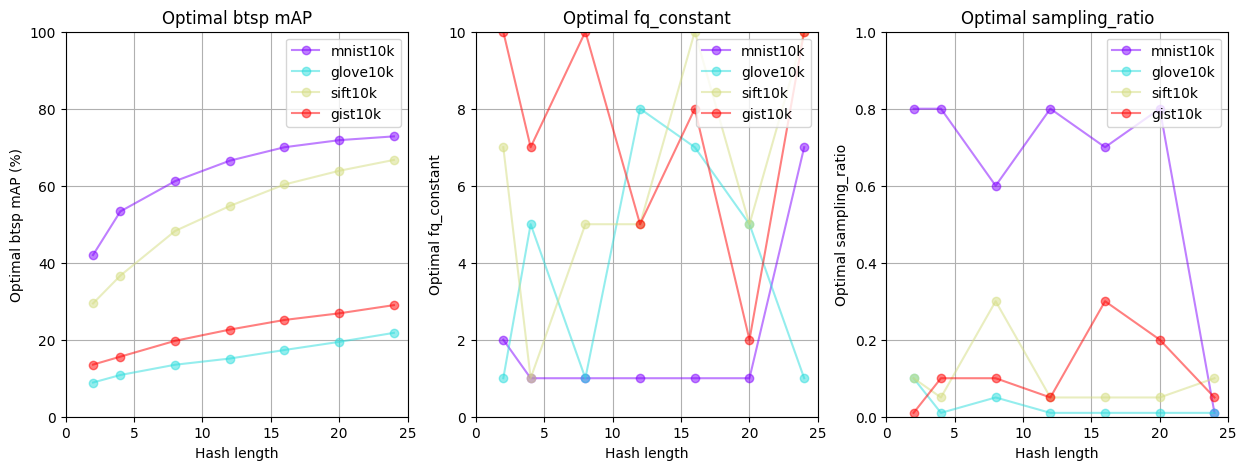

In [7]:
# load the fine-tuned results
results = pd.read_csv('optimal_btsp_mAP.csv')

# rename the columns
results = results.rename(columns={"btsp_fq_constant_x": "optimal_fq_constant", "btsp_sampling_ratio_x": "optimal_sampling_ratio"})
# scale mAP by percentage
results["btsp_mAP"] = results["btsp_mAP"] * 100

# for each dataset, plot the optimal btsp_mAP and its paramter setting against hash_length
datasets = ["mnist10k","glove10k","sift10k","gist10k"]
colors = plt.cm.rainbow(np.linspace(0, 1, len(datasets)))
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for dataset in datasets:
    curr_data = results[results["dataset_name"] == dataset]

    # first plot the optimal btsp_mAP against hash_length
    axs[0].plot(curr_data["hash_length"], curr_data["btsp_mAP"], marker='o', linestyle='-', color=colors[datasets.index(dataset)], alpha=0.5, label=dataset)
    # then plot the optimal parameter setting against hash_length
    axs[1].plot(curr_data["hash_length"], curr_data["optimal_fq_constant"], marker='o', linestyle='-', color=colors[datasets.index(dataset)], alpha=0.5, label=dataset)
    axs[2].plot(curr_data["hash_length"], curr_data["optimal_sampling_ratio"], marker='o', linestyle='-', color=colors[datasets.index(dataset)], alpha=0.5, label=dataset)

for ax in axs:
    ax.set_xlabel("Hash length")
    ax.set_xlim(0,25)
    ax.grid()
    ax.legend(loc="upper right")
axs[0].set_ylabel("Optimal btsp mAP (%)")
axs[0].set_ylim(0, 100)
axs[0].set_title(f"Optimal btsp mAP")
axs[1].set_ylabel("Optimal fq_constant")
axs[1].set_ylim(0, 10)
axs[1].set_title(f"Optimal fq_constant")
axs[2].set_ylabel("Optimal sampling_ratio")
axs[2].set_ylim(0, 1)
axs[2].set_title(f"Optimal sampling_ratio")

# save the plot as svg
plt.savefig("optimal_btsp_mAP.svg")
plt.show()
    
    

As shown in the figure, for all datasets optimal mAP has positive correlation with `hash_length`, while the other parameters have dataset-specific optimal values.

For the `minst10k` dataset, the optimal `fq_constant` remains stable except of `hash_length==25`, the same applies to `sampling_ratio`. Given these two parameters have very little impact on the performance, this could be a random fluctuation.

For other datasets, the optimal `fq_constant` does not have a clear pattern and the optimal `sampling_ratio` remains at a low level. Specifically, for `glove10k`, the optimal `sampling_ratio` is almost always 0.01.